## This program is the main function that runs the simulation such that
1. Compares raw job list with an altered job list. The comparison can be turned off so it only runs on raw job lists. <br>
2. Outputs two csv files for data, one from unaltered job list (called the Benchmark), another from altered joblist (called the Experiment). If the Monte-Carlo run is more than 1, only the last run will be saved. <br>
3. Provides two time series (benchmark and experiment) with time, number of forklifts at different status, number of them waiting on the each dropping off point, and the number of them on all dropping off points together. <br>
4. Provides a visualization and can save all the figrues for animation purposes. Read the specific part for detail. <br>

#  <font color=red>READ BEFORE YOU RUN THE CODE </font>
0. Run in Jupyter notebook for best result.
1. You need to run the main function at least once to get updated csv files for data analysis.<br>
2. If you want to test your own joblist optimizing function, change the function <font color=blue>order_tasks(job_list, WAREHOUSE_DIM) </font> at line 108 in the <font color=blue>main() </font> function block.
3. Global variables are in the control panel. Change them if needed. <br>
4. The arrow plotting part needs some better improvements, you can run that but it may not give what you want.<br>
5. There are several black boxes and private functions, private variables in the file. Try not to alter them as it might break the code. <br>

Hansen 07/17/2020 IMA Bootcamp

In [1]:
import itertools
import pandas as pd
import numpy as np
from simulation_w_list import Simulation as Sim_list
from simulation import Simulation as Sim_original
from scipy import stats

#%matplotlib notebook
%matplotlib inline
from ipywidgets import *
import matplotlib.pyplot as plt
import copy
import ast
import os
import time

# Simulation Part

In [14]:
"""
Control Panel. Change global variables here.
"""
# var 1: order of the forklifts jobs
# var 2: tasks within each job for each forklift
# try to minimize time

WAREHOUSE_DIM = 10  # size of warehouse
N_FORKLIFTS = 9  #number of forklifts available
RECEIVING = [0, 0]  # location of receiving
SHIPPING = [WAREHOUSE_DIM-1, WAREHOUSE_DIM-1]  # location of shipping
LAB = [0, WAREHOUSE_DIM-1]  # location of lab

IF_RUN_BENCHMARK = True
IF_RUN_EXPERIMENT = True

OUTPUT_TO_CSV_BM = False # whether we want a csv output file for benchmark
OUTPUT_TO_CSV_EP = False # whether we want a csv output file for experiment
IF_PRINT = False # if we want the simulation to print how much job is done
N_JOBS = 100 # number of jobs
N_RUNS = 500 # number of runs, for Monte-Carlo purpose

outputfile_bm = 'test_run_bm.csv' # saving the benchmark result
outputfile_ep = 'test_run_ep.csv' # saving the experimental result

In [15]:
def main():
    """
    Runs the Monte-Carlo code, generates total running time in order to
    compare a raw job list with an optimized job list.
    It also saves the running data to a csv file (Can be turned off).
    
    
    Input: nothing
    
    Output: a list of 2 (sub)lists: 
        -The 0th sub-list records the benchmark using a randomly generated joblist
        -The 1st sub_list records the pointwise-optimized joblist
    """
    print("Total number of runs:", N_RUNS)
    print("Total number of jobs for each run:", N_JOBS)
    print("Warehouse dimension is:", WAREHOUSE_DIM)
    print("The number of forklift is:", N_FORKLIFTS)
    print("Whether running a parallel experiment:", IF_RUN_EXPERIMENT)

    run_time_data = run_simulation(n_runs = N_RUNS,
                                   output_file_bm = outputfile_bm,
                                   output_file_ep = outputfile_ep,
                                   if_run_benchmark = IF_RUN_BENCHMARK,
                                   if_run_experiment = IF_RUN_EXPERIMENT,
                                   _if_print = IF_PRINT,
                                   _output_to_csv = [OUTPUT_TO_CSV_BM,OUTPUT_TO_CSV_EP],
                                   _receiving = RECEIVING,
                                   _shipping = SHIPPING,
                                   _lab = LAB,
                                   _warehouse_dim = WAREHOUSE_DIM,
                                   _n_forklifts = N_FORKLIFTS,
                                   _n_jobs = N_JOBS)
    print("Benchmark run time: ", run_time_data[0])
    print("Experiment run time: ", run_time_data[1])
        
    return run_time_data
    
def run_simulation(n_runs,
                   output_file_bm,
                   output_file_ep,
                   if_run_benchmark,
                   if_run_experiment,
                   _if_print,
                   _output_to_csv,
                   _receiving,
                   _shipping,
                   _lab,
                   _warehouse_dim,
                   _n_forklifts, 
                   _n_jobs):
    """
    Black box. Do not alter stuff except for changing the optimized job list.
    """
    Benchmark_time_data = np.zeros(n_runs)
    Experiment_time_data = np.zeros(n_runs)
    for run_number in range(0,n_runs):
        raw_job_list = [generate_random_job(warehouse_dim = _warehouse_dim) for k in range(_n_jobs)]
        """ This boxed part below is the place that you can change"""
        ######### This is where you optimize joblist ##########
        job_list = raw_job_list # order_tasks(raw_job_list, _warehouse_dim)
        job_assignment = shuffle_job_index(n_forklifts = N_FORKLIFTS, n_jobs=N_JOBS) # randomly assign stuff
        #print("raw job list", raw_job_list)
        #print("changed job list", job_list)
        #######################################################
        #Set up the simulation with the RAW joblist
        if if_run_benchmark == True:
            if run_number < n_runs - 1:
                test_benchmark = Sim_original(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_job_lists=raw_job_list,
                                  #job_assign_list = job_assignment,
                                  output_to_csv = False, # boolean, we want to skip those
                                  if_print = _if_print) # boolean
                Benchmark_time_data[run_number] = test_benchmark.run(output_file_bm)
            elif run_number == n_runs - 1: 
                test_benchmark = Sim_original(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_job_lists=raw_job_list,
                                  #job_assign_list = job_assignment, #list(range(_n_forklifts)),
                                  output_to_csv = _output_to_csv[0], # we want to output only the last one
                                  if_print = _if_print) # boolean
                Benchmark_time_data[run_number] = test_benchmark.run(output_file_bm)
        
        #Set up the simulation with a CHANGED joblist
        if if_run_experiment == True:
            #print("n_runs = ", run_number)
            if run_number < n_runs - 1:
                test_experiment = Sim_list(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_job_lists=job_list,
                                  job_assign_list = job_assignment,
                                  output_to_csv = False,#_output_to_csv, # boolean
                                  if_print = _if_print) # boolean
                Experiment_time_data[run_number] = test_experiment.run(output_file_ep)
            elif run_number == n_runs - 1:
                test_experiment = Sim_list(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_job_lists=job_list,
                                  job_assign_list = job_assignment,
                                  output_to_csv = _output_to_csv[1],#_output_to_csv, # boolean
                                  if_print = _if_print) # boolean
                Experiment_time_data[run_number] = test_experiment.run(output_file_ep)
        
    return [Benchmark_time_data, Experiment_time_data]

# def generate_random_job(warehouse_dim = WAREHOUSE_DIM, 
#                         receiving = RECEIVING, 
#                         shipping = SHIPPING, 
#                         lab = LAB):
#     """
#     This function generates a raw job list randomly, providing the raw_job_list object
#     that we need to optimize on. 
#     Below is the blackbox that thy shall not touch. 
#     """
#     job_length = 1 + np.random.randint(3)
#     raw_job = np.random.randint(warehouse_dim, size=job_length*2)
#     destination = [receiving, shipping, lab][np.random.choice([0,1,2])]
#     raw_job = np.append(raw_job, destination)
#     raw_job = raw_job.reshape(job_length + 1, 2)
#     return raw_job
def shuffle_job_index(n_forklifts = N_FORKLIFTS, n_jobs=N_JOBS):
    base = np.arange(N_FORKLIFTS)
    np.random.shuffle(base)
    job_assignment = np.random.choice(range(N_FORKLIFTS),N_JOBS-N_FORKLIFTS)
    result = np.concatenate((base, job_assignment), axis=None)
    np.random.shuffle(result)
    return list(result)

def generate_random_job(warehouse_dim = WAREHOUSE_DIM, 
                        receiving = RECEIVING, 
                        shipping = SHIPPING, 
                        lab = LAB):
    job_length = 1 + np.random.randint(3) #1 + np.random.randint(3) # number of tasks
    job = np.random.randint(warehouse_dim, size=job_length*2)
    for i in range(0,job_length-1):
        while (job[2*i]==RECEIVING[0] and job[2*i+1]==RECEIVING[1]) or (job[2*i]==SHIPPING[0] and job[2*i+1]==SHIPPING[1]) or (job[2*i]==LAB[0] and job[2*i+1]==LAB[1]):
            job = np.random.randint(warehouse_dim, size=job_length*2)
    destination = [receiving, shipping, lab][np.random.choice([0,1,2])]
    if destination == receiving:
        job = np.insert(job, 0, destination)
    else:
        job = np.append(job, destination)
    job = job.reshape(job_length + 1, 2)
    return job


####################################################################################
####################################################################################
####################################################################################
### Below are the candidates for optimizing the job list ###########################
def order_tasks(job_list, WAREHOUSE_DIM):
    import copy
    """
    This orders the tasks within a certain job to minimize distance
    This does not take into account the original location of the forklift
    NOTE: distance \neq time since time had an error
    """
    
    for i in range(0,len(job_list)): #optimize each job
        job = copy.copy(job_list[i]) #consider a single job
        N_TASKS = len(job)-1 #number of tasks
        
        distance = WAREHOUSE_DIM*len(job)+1 #make this large, this is what we need to beat
        if all(job[0] == [0,0]): #change this to RECEIVING
            for perm in itertools.permutations(job[1:],N_TASKS): #potential permutations
                this_dist = 0 #the distance for this permutation
                for j in range(1,N_TASKS-1):
                    this_dist += abs(perm[j][0]-perm[j+1][0]) + abs(perm[j][1]-perm[j+1][1]) #add distance between tasks
                this_dist += abs(perm[0][0] - job[0][0]) + abs(perm[0][1] - job[0][1]) #add distance to delivery point
                
                if this_dist < distance: #better permutation
                    distance = this_dist
                    job_list[i][1:N_TASKS+1] = list(perm)
        else:
            for perm in itertools.permutations(job[:N_TASKS],N_TASKS): #potential permutations
                this_dist = 0 #the distance for this permutation
                for j in range(0,N_TASKS-1):
                    this_dist += abs(perm[j][0]-perm[j+1][0]) + abs(perm[j][1]-perm[j+1][1]) #add distance between tasks
                this_dist += abs(perm[N_TASKS-1][0] - job[N_TASKS][0]) + abs(perm[N_TASKS-1][1] - job[N_TASKS][1]) #add distance to delivery point
                    
                if this_dist < distance: #better permutation
                    distance = this_dist
                    job_list[i][0:N_TASKS] = list(perm)
    return job_list

In [16]:
start_time = time.time()
run_time_data = main()
print('It took %i seconds to run' %(time.time()-start_time))

Total number of runs: 500
Total number of jobs for each run: 100
Warehouse dimension is: 10
The number of forklift is: 9
Whether running a parallel experiment: True
Benchmark run time:  [855. 912. 837. 830. 916. 862. 815. 832. 821. 881. 829. 841. 821. 854.
 836. 791. 860. 782. 875. 849. 843. 798. 870. 838. 847. 872. 854. 846.
 857. 882. 832. 872. 834. 800. 851. 889. 854. 839. 843. 834. 818. 853.
 849. 880. 832. 820. 847. 843. 812. 813. 888. 937. 797. 813. 821. 828.
 849. 824. 839. 809. 868. 838. 812. 862. 877. 801. 846. 846. 882. 917.
 851. 823. 878. 842. 841. 853. 860. 837. 860. 819. 850. 896. 845. 885.
 865. 864. 845. 907. 814. 809. 855. 851. 868. 817. 864. 832. 850. 827.
 880. 876. 783. 793. 853. 810. 807. 859. 806. 863. 885. 832. 836. 814.
 881. 868. 820. 827. 857. 801. 908. 798. 894. 830. 809. 825. 866. 779.
 866. 840. 812. 781. 850. 867. 934. 841. 781. 849. 855. 876. 860. 850.
 857. 923. 887. 825. 846. 835. 783. 849. 836. 861. 847. 844. 799. 811.
 832. 824. 885. 803. 822. 792. 87

# Primitive Data Analysis, No CSV Needed

The benchmark average is  843.186 The benchmark std is  29.193687742387052
The experiment average is  997.69 The experiment std is  82.15790832293627
The p-value from Welch's t-test is 3.264687593665004e-172
Difference is significant


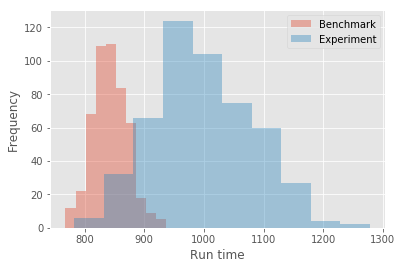

In [19]:
avg_bm = np.average(run_time_data[0])
std_bm = np.std(run_time_data[0])
print("The benchmark average is ", avg_bm, "The benchmark std is ", std_bm)

avg_ep = np.average(run_time_data[1])
std_ep = np.std(run_time_data[1])
print("The experiment average is ", avg_ep, "The experiment std is ", std_ep)

# perform a Welch's t-test, assuming different variations from both samples
t_test_result = stats.ttest_ind(run_time_data[0],run_time_data[1], equal_var = False)
fail_reject_null_hypothesis = (t_test_result[1] > 0.05)
print("The p-value from Welch\'s t-test is", t_test_result[1])
if fail_reject_null_hypothesis:
    print("Difference is insignificant, fail to reject the null hypothesis")
else:
    print("Difference is significant")

plt.style.use('ggplot')
plt.figure()
plt.hist(run_time_data[0], alpha = 0.4, label = 'Benchmark')
plt.hist(run_time_data[1], alpha = 0.4, label = 'Experiment')
plt.legend(loc='upper right')
plt.xlabel('Run time')
plt.ylabel('Frequency')
plt.show()

# Need A .csv File to work with

In [19]:
# load the data, and check if it is successfully loaded
try:
    df_bm = pd.read_csv('test_run_bm.csv')
    print(df_bm.tail(10))
    print(len(df_bm)/N_FORKLIFTS)

    df_ep = pd.read_csv('test_run_ep.csv')
    print(df_ep.tail(10))
    print(len(df_ep)/N_FORKLIFTS)
except:
    print("There are no csv files in current your folder.",
          "Go back to the control panel to make sure you have some csv file to begin with")

      time        name current_destination last_loc    status  \
4670   155  Forklift20              [0, 9]   [3, 7]  complete   
4671   155  Forklift21              [5, 9]   [2, 0]  complete   
4672   155  Forklift22              [9, 9]   [1, 6]  complete   
4673   155  Forklift23              [9, 9]   [9, 3]  complete   
4674   155  Forklift24              [0, 9]   [4, 6]  complete   
4675   155  Forklift25              [9, 9]   [4, 3]  complete   
4676   155  Forklift26              [8, 3]   [2, 0]  complete   
4677   155  Forklift27              [9, 9]   [7, 4]  complete   
4678   155  Forklift28              [0, 9]   [3, 5]  complete   
4679   155  Forklift29              [9, 9]   [8, 7]  complete   

      next_update_time  
4670              85.0  
4671             117.0  
4672              83.0  
4673             115.0  
4674              77.0  
4675             103.0  
4676              89.0  
4677              82.0  
4678              88.0  
4679             138.0  
936.0
   

# Arrow Plot

In [20]:
"""
Plots a vector field at a given global time spot.
Dot: a forklift's last known position
Arrow: pointing from last position to the next position
Arrow colors: green    - traveling
              yellow   - picking
              red      - waiting
              no plot  - complete
"""

def plot_save_vector_graph(data_frame, if_save_fig = False):
    df = data_frame
    isf = if_save_fig # whether you want figures to save or not
    end_time = df["time"].max()
    
    for t in range(0,end_time+1):
        picture = plot_given_time(_data_from_feeder = _feeder(_dataframe = df, _target_time = t),
                              if_save_fig = isf)
    print(type(picture))
        
def plot_given_time(_data_from_feeder, if_save_fig = False):
#    %matplotlib inline
    # saving figure defalt to false
    _time = _data_from_feeder[0]
    _last_loc = _data_from_feeder[1]
    _destination = _data_from_feeder[2]
    _status = _data_from_feeder[3]
    _next_update_time = _data_from_feeder[4]
    
    _last_loc = _last_loc.values.tolist()
    for i in range(len(_last_loc)):
        _last_loc[i] = _str_to_list(_last_loc[i])
    _last_loc = np.array(_last_loc)
    #print(_last_loc)
    
    _destination = _destination.values.tolist()
    for i in range(len(_destination)):
        _destination[i] = _str_to_list(_destination[i])
    _destination = np.array(_destination)
    #print(_destination)
    
    # cast _status into a list _status_list for easier manipulation
    _status_list = _status.values.tolist()

    fig = plt.figure(figsize=(10,10))
    #plotting the last location & destination
    plt.scatter(_last_loc[:,0],_last_loc[:,1],s=60)
    plt.scatter(_destination[:,0],_destination[:,1],s=60)
    for i in range(len(_destination)): # iterate thru each forklift
        if _status_list[i] == 'traveling':
            plt.arrow(_last_loc[i,0],_last_loc[i,1],
                      _destination[i,0]-_last_loc[i,0],
                      _destination[i,1]-_last_loc[i,1],
                      head_width = 0.1, 
                      color = 'g')
        elif _status_list[i] == 'picking':
            plt.arrow(_last_loc[i,0],_last_loc[i,1],
                      _destination[i,0]-_last_loc[i,0],
                      _destination[i,1]-_last_loc[i,1],
                      head_width = 0.1, 
                      color = 'y')
        elif _status_list[i] == 'waiting':
            plt.arrow(_last_loc[i,0],_last_loc[i,1],
                      _destination[i,0]-_last_loc[i,0],
                      _destination[i,1]-_last_loc[i,1],
                      head_width = 0.1, 
                      color = 'r')
        elif _status_list[i] == 'complete':
            continue
          

    plt.xlim(-2,WAREHOUSE_DIM+1)
    plt.ylim(-2,WAREHOUSE_DIM+1)
    #plt.axis('scaled')
    plt.title("Time = %i" %_time)
    if if_save_fig == True:
        try:
            plt.savefig('figure/time%i' %_time + '.png')
        except:
            os.makedirs('figure')
            plt.savefig('figure/time%i' %_time + '.png')
    plt.close(fig)
    return fig
        
    
def _str_to_list(_string):
    res = ast.literal_eval(_string) 
    return res

def _feeder(_dataframe,_target_time):
    df = _dataframe
    # slice the time
    _time = _target_time
    
    subframe = df[df['time'] == _time]
    _last_loc = subframe['last_loc']
    _destination = subframe['current_destination']
    _status = subframe['status']
    _next_update_time = subframe['next_update_time']
    
    return[_time,
           _last_loc, 
           _destination, 
           _status, 
           _next_update_time]


In [21]:
"""
Remark: It seems quite cumbersome to make animations inside Jupyter so I simply gave up. One animation method 
can run on my computer but in order for it to run on yours you will need to download some widgets and it is 
quite complicated.
Here is the way around it: I will make it save all the figures, and you can feel free to use 3rd party
software to make a stop motion movie. Recommend qStopMotion.
If you want to run through the data to output ALL plot files for ALL time, uncomment line 10.
If you just want to see a plot at a specific time, uncomment line 11-12.
"""
plot_save_vector_graph(data_frame = df_ep, if_save_fig = False)
#plot_given_time(_data_from_feeder = _feeder(_dataframe = df_ep, _target_time = 180),
#                              if_save_fig = False)

<class 'matplotlib.figure.Figure'>


# Time Series Analysis Part, Need A csv File, Need To Run The Previous Code Block

In [22]:
def get_status_data(_data_from_feeder):
    """read from the feeder (at a given time frame), then produces an numpy of 5 components:
clock time, 
number of forklifts waiting, 
number of forklifts traveling,
number of forklifts picking,
number of forklifts completed the work,
number of forklifts waiting for the dropoff points = 
[time, n_wait, n_travel, n_pick, n_complete, n_wait_dropoff]
    """
    _time = _data_from_feeder[0]
    _last_loc = _data_from_feeder[1]
    _destination = _data_from_feeder[2]
    _status = _data_from_feeder[3]
    _next_update_time = _data_from_feeder[4]
    _length = len(_status)
    
    time = _time
    n_wait = _status[_status == "waiting"].count()
    n_travel = _status[_status == "traveling"].count()
    n_pick = _status[_status == "picking"].count()
    n_complete = _status[_status == "complete"].count()
    
    # change _destination into a np array for vectorized manipulation
    _destination = _destination.values.tolist()
    for i in range(len(_destination)):
        _destination[i] = _str_to_list(_destination[i])
    _destination = np.array(_destination)
    
    # cast _status into a list _status_list for easier manipulation
    _status_list = _status.values.tolist()
    
    n_wait_dropoff = 0 # initialize to 0
    n_wait_lab = 0
    n_wait_ship = 0
    n_wait_receive = 0
    for i in range(_length):
        if_LAB = (_destination[i][0] == LAB[0] and _destination[i][1] == LAB[1])
        if_SHIPPING = (_destination[i][0] == SHIPPING[0] and _destination[i][1] == SHIPPING[1])
        if_RECEIVING = (_destination[i][0] == RECEIVING[0] and _destination[i][1] == RECEIVING[1])
        if if_LAB+if_SHIPPING+if_RECEIVING == True: #either shipping, receiving or lab
            if _status_list[i] == 'waiting':
                n_wait_dropoff += 1
                if if_LAB == True:
                    n_wait_lab += 1
                if if_SHIPPING == True:
                    n_wait_ship += 1
                if if_RECEIVING == True:
                    n_wait_receive += 1
                
    return [time, 
            n_wait, 
            n_travel, 
            n_pick, 
            n_complete, 
            n_wait_dropoff, 
            n_wait_lab, 
            n_wait_ship, 
            n_wait_receive]

#    print(time, n_wait, n_travel, n_pick, n_complete, n_wait_dropoff)
 #   print(_destination, type(_destination))
#    print(_status_list, type(_status_list))

df_bm = pd.read_csv('test_run_bm.csv')
print(df_bm.tail(5))
print(len(df_bm)/N_FORKLIFTS)

time_series_data_bm = np.empty([df_bm["time"].max()+1,9])
time_series_data_bm[-1][:] = [df_bm["time"].max()+1, 0,0,0,N_FORKLIFTS,0,0,0,0]
            
for i in range(0,df_bm["time"].max()):
    time_series_data_bm[i][:] = \
    get_status_data(_data_from_feeder = _feeder(_dataframe = df_bm, _target_time = i))
    
df_ep = pd.read_csv('test_run_ep.csv')
print(df_ep.tail(5))
print(len(df_ep)/N_FORKLIFTS)

time_series_data_ep = np.empty([df_ep["time"].max()+1,9])
time_series_data_ep[-1][:] = [df_ep["time"].max()+1, 0,0,0,N_FORKLIFTS,0,0,0,0]
            
for i in range(0,df_ep["time"].max()):
    time_series_data_ep[i][:] = \
    get_status_data(_data_from_feeder = _feeder(_dataframe = df_ep, _target_time = i))

      time        name current_destination last_loc    status  \
4675   155  Forklift25              [9, 9]   [4, 3]  complete   
4676   155  Forklift26              [8, 3]   [2, 0]  complete   
4677   155  Forklift27              [9, 9]   [7, 4]  complete   
4678   155  Forklift28              [0, 9]   [3, 5]  complete   
4679   155  Forklift29              [9, 9]   [8, 7]  complete   

      next_update_time  
4675             103.0  
4676              89.0  
4677              82.0  
4678              88.0  
4679             138.0  
936.0
      time        name current_destination last_loc    status  \
4315   143  Forklift25              [0, 9]   [4, 9]  complete   
4316   143  Forklift26              [9, 9]   [9, 6]  complete   
4317   143  Forklift27              [5, 9]   [2, 0]  complete   
4318   143  Forklift28              [9, 9]   [8, 9]  complete   
4319   143  Forklift29              [9, 9]   [1, 6]  complete   

      next_update_time  
4315             114.0  
4316        

# Plotting the time series from a specific csv file

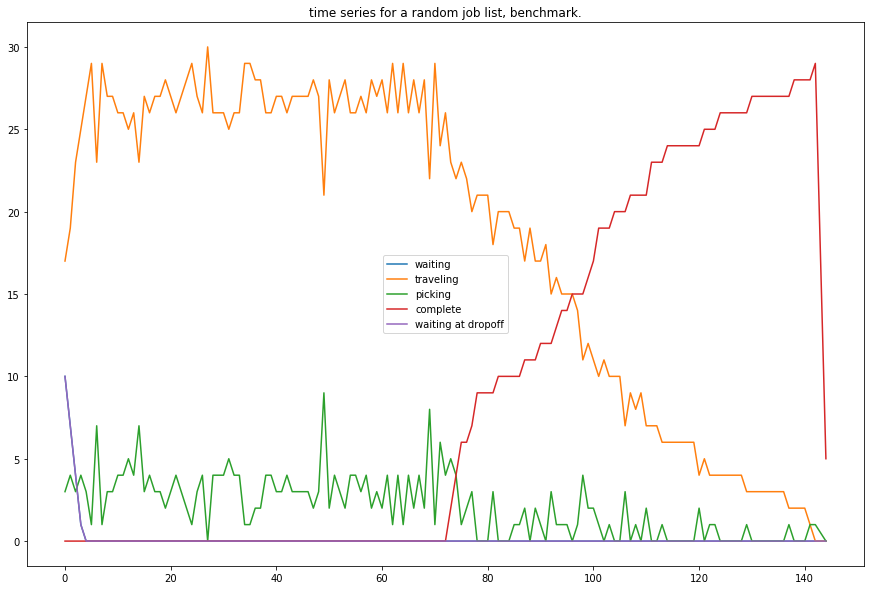

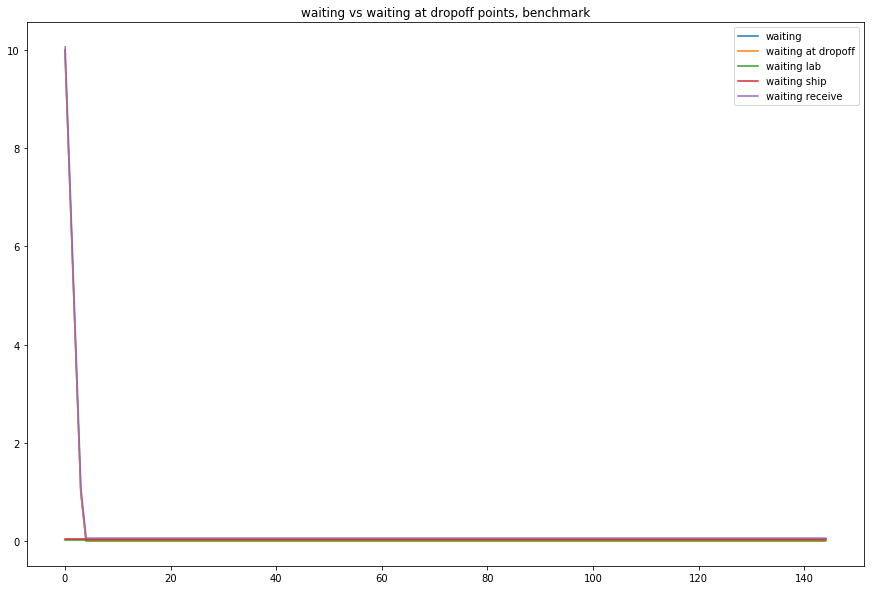

In [23]:
"""
Plotting for the benchmark
"""
ts1 = time_series_data_ep
labels = ['waiting', 'traveling', 'picking', 'complete', 'waiting at dropoff']
plt.figure(figsize=(15,10))
plt.plot(ts1[:,0],ts1[:,1])
plt.plot(ts1[:,0],ts1[:,2])
plt.plot(ts1[:,0],ts1[:,3])
plt.plot(ts1[:,0],ts1[:,4])
plt.plot(ts1[:,0],ts1[:,5])
plt.title('time series for a random job list, benchmark.')
plt.legend(labels)
plt.show()

labels = ['waiting', 'waiting at dropoff', 'waiting lab','waiting ship','waiting receive']
plt.figure(figsize=(15,10))
plt.plot(ts1[:,0],ts1[:,1])
plt.plot(ts1[:,0],ts1[:,5])
plt.plot(ts1[:,0]+0.02,ts1[:,6]+0.02)
plt.plot(ts1[:,0]+0.04,ts1[:,7]+0.04)
plt.plot(ts1[:,0]+0.06,ts1[:,8]+0.06)
plt.title('waiting vs waiting at dropoff points, benchmark')
plt.legend(labels)
plt.show()

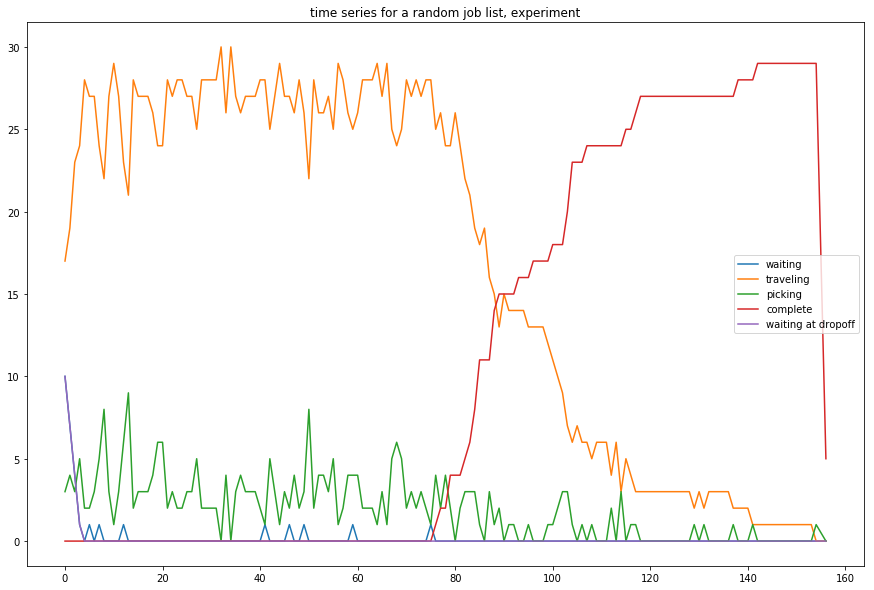

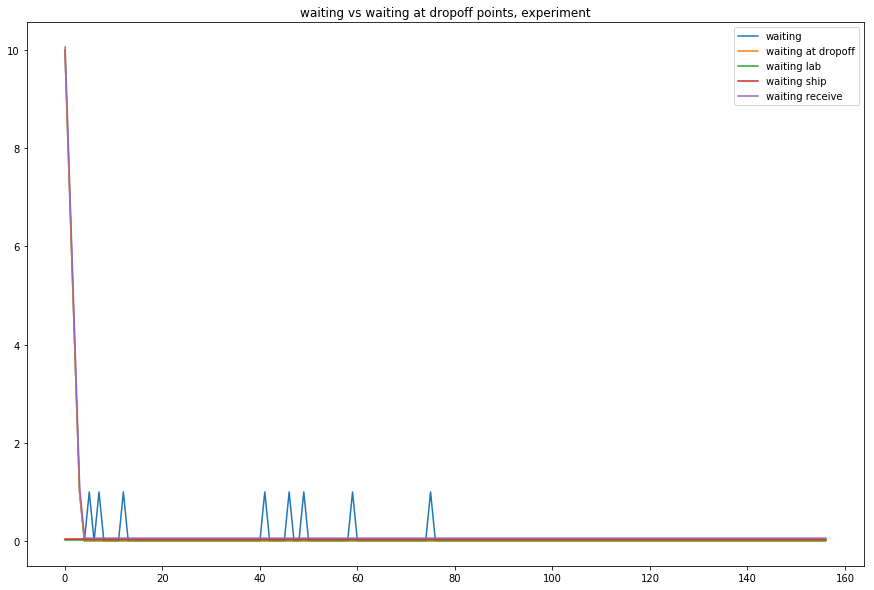

In [24]:
"""
Plotting for the experiment
"""
ts2 = time_series_data_bm
labels = ['waiting', 'traveling', 'picking', 'complete', 'waiting at dropoff']
plt.figure(figsize=(15,10))
plt.plot(ts2[:,0],ts2[:,1])
plt.plot(ts2[:,0],ts2[:,2])
plt.plot(ts2[:,0],ts2[:,3])
plt.plot(ts2[:,0],ts2[:,4])
plt.plot(ts2[:,0],ts2[:,5])
plt.title('time series for a random job list, experiment')
plt.legend(labels)
plt.show()

labels = ['waiting', 'waiting at dropoff', 'waiting lab','waiting ship','waiting receive']
plt.figure(figsize=(15,10))
plt.plot(ts2[:,0],ts2[:,1])
plt.plot(ts2[:,0],ts2[:,5])
plt.plot(ts2[:,0]+0.02,ts2[:,6]+0.02)
plt.plot(ts2[:,0]+0.04,ts2[:,7]+0.04)
plt.plot(ts2[:,0]+0.06,ts2[:,8]+0.06)
plt.title('waiting vs waiting at dropoff points, experiment')
plt.legend(labels)
plt.show()

# Crap underneath is irrevelant scratch paper stuff